Group PGH013: Dhruv Baid, Guolun Li, Shangyu Li, Uday Sharma, Yi Xin Xiang

In [15]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
plt.style.use("seaborn")

**Preprocessing – delete once merged**

In [2]:
df = pd.read_csv('OFFERING.tsv', sep='\t')

In [3]:
df.loc[df.HASNONACCREDITEDINVESTORS == False,'NUMBERNONACCREDITEDINVESTORS']\
     =df[df.HASNONACCREDITEDINVESTORS == False].\
        NUMBERNONACCREDITEDINVESTORS.fillna(0)

df.loc[df.TOTALNUMBERALREADYINVESTED < df.NUMBERNONACCREDITEDINVESTORS,\
     'TOTALNUMBERALREADYINVESTED'] = \
     df.loc[df.TOTALNUMBERALREADYINVESTED < \
        df.NUMBERNONACCREDITEDINVESTORS, 'NUMBERNONACCREDITEDINVESTORS']

df.IS40ACT = df.IS40ACT.fillna('Not Applicable')

df.INVESTMENTFUNDTYPE = df.INVESTMENTFUNDTYPE.fillna("Not Applicable")

df.REVENUERANGE = df.REVENUERANGE.fillna("Not Applicable")
df.AGGREGATENETASSETVALUERANGE = df.AGGREGATENETASSETVALUERANGE.\
    fillna("Not Applicable")

df.PREVIOUSACCESSIONNUMBER = df.PREVIOUSACCESSIONNUMBER.\
    fillna("Not Applicable")

df.YETTOOCCUR = df.YETTOOCCUR.fillna(False)
df.ISEQUITYTYPE = df.ISEQUITYTYPE.fillna(False)
df.ISDEBTTYPE = df.ISDEBTTYPE.fillna(False)
df.ISOPTIONTOACQUIRETYPE = df.ISOPTIONTOACQUIRETYPE.fillna(False)
df.ISSECURITYTOBEACQUIREDTYPE = df.ISSECURITYTOBEACQUIREDTYPE.fillna(False)
df.ISPOOLEDINVESTMENTFUNDTYPE = df.ISPOOLEDINVESTMENTFUNDTYPE.fillna(False)
df.ISTENANTINCOMMONTYPE = df.ISTENANTINCOMMONTYPE.fillna(False)
df.ISMINERALPROPERTYTYPE = df.ISMINERALPROPERTYTYPE.fillna(False)
df.ISOTHERTYPE = df.ISOTHERTYPE.fillna(False)

df.DESCRIPTIONOFOTHERTYPE = df.DESCRIPTIONOFOTHERTYPE.\
    fillna('Not Applicable')

df.BUSCOMBCLARIFICATIONOFRESP = df.BUSCOMBCLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.SALESAMTCLARIFICATIONOFRESP = df.SALESAMTCLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.FINDERFEECLARIFICATIONOFRESP = df.FINDERFEECLARIFICATIONOFRESP.\
    fillna("Not Applicable")
df.GROSSPROCEEDSUSED_CLAROFRESP = df.GROSSPROCEEDSUSED_CLAROFRESP.\
    fillna("Not Applicable")

df = df.drop(columns=['OVER100RECIPIENTFLAG'])

df.SALESCOMM_ISESTIMATE = df.SALESCOMM_ISESTIMATE.fillna(False)
df.FINDERSFEE_ISESTIMATE = df.FINDERSFEE_ISESTIMATE.fillna(False)
df.GROSSPROCEEDSUSED_ISESTIMATE = df.GROSSPROCEEDSUSED_ISESTIMATE.\
    fillna(False)

In [4]:
df.MINIMUMINVESTMENTACCEPTED = df.MINIMUMINVESTMENTACCEPTED.\
    astype('float64')
df.TOTALOFFERINGAMOUNT = df.TOTALOFFERINGAMOUNT.\
    replace('Indefinite',np.inf).astype('float64')
df.TOTALAMOUNTSOLD = df.TOTALAMOUNTSOLD.astype('float64')
df.TOTALREMAINING = df.TOTALREMAINING.replace('Indefinite',\
    np.inf).astype('float64')
df.NUMBERNONACCREDITEDINVESTORS = \
    df.NUMBERNONACCREDITEDINVESTORS.astype('float64')
df.TOTALNUMBERALREADYINVESTED = df.TOTALNUMBERALREADYINVESTED\
    .astype('int64')
df.SALESCOMM_DOLLARAMOUNT = df.SALESCOMM_DOLLARAMOUNT\
    .astype('float64')
df.FINDERSFEE_DOLLARAMOUNT = df.FINDERSFEE_DOLLARAMOUNT\
    .astype('float64')
df.GROSSPROCEEDSUSED_DOLLARAMOUNT = \
    df.GROSSPROCEEDSUSED_DOLLARAMOUNT.astype('float64')

df.ISAMENDMENT = df.ISAMENDMENT.astype(bool)
df.YETTOOCCUR = df.YETTOOCCUR.astype(bool)
df.MORETHANONEYEAR = df.MORETHANONEYEAR.astype(bool)
df.ISEQUITYTYPE = df.ISEQUITYTYPE.astype(bool)
df.ISDEBTTYPE = df.ISDEBTTYPE.astype(bool)
df.ISOPTIONTOACQUIRETYPE = df.ISOPTIONTOACQUIRETYPE.astype(bool)
df.ISSECURITYTOBEACQUIREDTYPE = df.ISSECURITYTOBEACQUIREDTYPE.astype(bool)
df.ISPOOLEDINVESTMENTFUNDTYPE = df.ISPOOLEDINVESTMENTFUNDTYPE.astype(bool)
df.ISTENANTINCOMMONTYPE = df.ISTENANTINCOMMONTYPE.astype(bool)
df.ISMINERALPROPERTYTYPE = df.ISMINERALPROPERTYTYPE.astype(bool)
df.ISOTHERTYPE = df.ISOTHERTYPE.astype(bool)
df.ISBUSINESSCOMBINATIONTRANS = df.ISBUSINESSCOMBINATIONTRANS.astype(bool)
df.HASNONACCREDITEDINVESTORS = df.HASNONACCREDITEDINVESTORS.astype(bool)
df.SALESCOMM_ISESTIMATE = df.SALESCOMM_ISESTIMATE.astype(bool)
df.FINDERSFEE_ISESTIMATE = df.FINDERSFEE_ISESTIMATE.astype(bool)
df.GROSSPROCEEDSUSED_ISESTIMATE = df.GROSSPROCEEDSUSED_ISESTIMATE\
    .astype(bool)

df.INDUSTRYGROUPTYPE = df.INDUSTRYGROUPTYPE.astype('category')
df.INVESTMENTFUNDTYPE = df.INVESTMENTFUNDTYPE.astype('category')
df.IS40ACT = df.IS40ACT.astype('category')
df.REVENUERANGE = df.REVENUERANGE.astype('category')
df.AGGREGATENETASSETVALUERANGE = df.AGGREGATENETASSETVALUERANGE\
    .astype('category')
df.AUTHORIZEDREPRESENTATIVE = df.AUTHORIZEDREPRESENTATIVE.astype('category')

df.SALE_DATE = df.SALE_DATE.astype('datetime64')

**end delete**

# Analysis 1

**Question**: Are there variables in the data set that could help predict the percentage of offering sold?

**Methods Used**: Natural Language Processing, K-Means Clustering

**Methodology**

First, we set up the response variable **y**, equal to the percentage of offering sold.

$$y = \frac{\mathrm{TOTALAMOUNTSOLD}}{\mathrm{TOTALOFFERINGAMOUNT}}$$

Note that we discard the rows where the total offering amount is undetermined.

In [5]:
idx = (df.TOTALOFFERINGAMOUNT!=np.inf)
y = (df.TOTALAMOUNTSOLD[idx] / df.TOTALOFFERINGAMOUNT[idx])

For performing Natural Language Processing, we look at the following columns with text data:
- DESCRIPTIONOFOTHERTYPE
- BUSCOMBCLARIFICATIONOFRESP
- SALESAMTCLARIFICATIONOFRESP
- FINDERFEECLARIFICATIONOFRESP
- GROSSPROCEEDSUSED_CLAROFRESP

First, we tokenize each column using the following methodology:
- tokenize by words 
- use regex to get alnum/special chars
- convert to lower IF not acronym
- remove stop words
- speech tagging then lemmatize

TODO: empty string

TODO: drop empty rows (no value there) – can explore further

TODO: acronym – keep ; series A

many are none so merge 


In [6]:
text_cols = ['DESCRIPTIONOFOTHERTYPE','BUSCOMBCLARIFICATIONOFRESP','SALESAMTCLARIFICATIONOFRESP','FINDERFEECLARIFICATIONOFRESP','GROSSPROCEEDSUSED_CLAROFRESP']
X_input = df[text_cols][idx].replace("Not Applicable",'')

lem = WordNetLemmatizer().lemmatize
stop_words = set(stopwords.words('english'))

print_bool = False
print_idx = np.random.choice(list(range(len(X_input)*len(text_cols))),50)
if not print_bool:
    print_idx = []
curr_idx = 0

def tokenize(string):
    global curr_idx
    curr_idx+=1

    if string=='':
        return []
    wt = word_tokenize(string)
    #wt = [word.lower() for word in wt if (word.isalnum() or word in [''])]
    wt = [word for word in wt if re.match("[a-zA-Z\$0-9].*",word) is not None]
    wt = list(map(lambda x: x if x.isupper() else x.lower(),wt))
    wt = [w for w in wt if not w in stop_words]
    wt = nltk.pos_tag_sents([wt])[0]
    holdsent = list(wt)
    for i, wordtuple in enumerate(holdsent):
        wordtmp = list(wordtuple)
        if(wordtmp[1].startswith('N')):
            wordtmp[1] = lem(wordtmp[0], 'n')
        elif(wordtmp[1].startswith('V')):
            wordtmp[1] = lem(wordtmp[0], 'v')
        elif(wordtmp[1].startswith('J')):
            wordtmp[1] = lem(wordtmp[0], 'a')
        elif(wordtmp[1].startswith('R')):
            wordtmp[1] = lem(wordtmp[0], 'r')
        else:
            wordtmp[1] = None
        holdsent[i] = wordtmp
    wt = list(map(lambda x: x[1] if x[1] is not None else x[0], holdsent))
    wt = mark_negation(wt)
    
    if curr_idx in print_idx:
    #if True:
        print(string)
        print(wt)
        print()
        
    return wt

for col in text_cols:
    X_input[col] = X_input[col].apply(tokenize)

X_input['combined_text'] = X_input.apply(lambda x: x[0]+x[1]+x[2]+x[3]+x[4],axis=1)
X_input.combined_text = list(map(lambda x: x if x else np.nan, X_input.combined_text))

In [7]:
idx_pick = X_input.combined_text.dropna().index
X, y = X_input.combined_text[idx_pick], y[idx_pick]

In [8]:
def dummy_tokenizer(sent):
    return sent

def dummy_preprocessor(sent):
    return sent

vectorizer = TfidfVectorizer(tokenizer = dummy_tokenizer, preprocessor=dummy_preprocessor)
vect_fit = vectorizer.fit_transform(list(X))

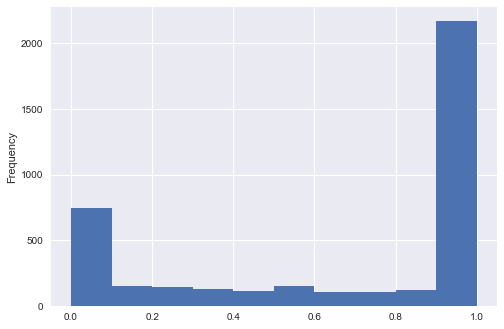

In [9]:
y.plot.hist(bins=10)

In [10]:
def bin_proportion(val, num_bins = 5):
    size = 1/num_bins
    i = size
    while val >= i:
        i += size
    return int(i//size)
        
y_binned = y.apply(bin_proportion)

TODO: number of clusters – "granularity" of clustering

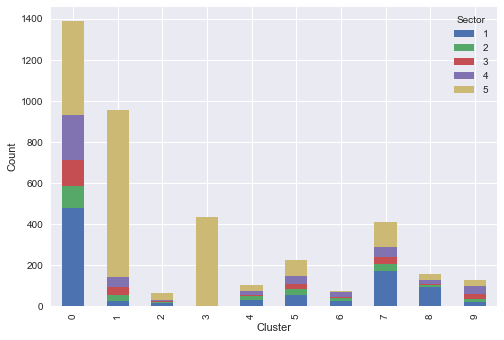

In [11]:
from sklearn.cluster import KMeans
kminit = KMeans(n_clusters=10, n_init=100)
kmout = kminit.fit(vect_fit.todense())

plot_df = pd.DataFrame(df.ACCESSIONNUMBER[X.index])
plot_df['kmclust'] = kmout.labels_
plot_df['kmclust'] = plot_df['kmclust'].astype('category').cat.as_unordered()
plot_df['actual_bin'] = y_binned.copy()

plot_df = plot_df.groupby(['kmclust','actual_bin'])['ACCESSIONNUMBER'].count().unstack('actual_bin').fillna(0)
plot_df.plot(kind='bar', stacked=True,legend=False)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Sector", bbox_to_anchor=(1.0, 1.0))
plt.show()

In [12]:
idx = y_binned[kmout.labels_ == 8].index

In [13]:
df[text_cols+['TOTALOFFERINGAMOUNT','TOTALAMOUNTSOLD']].iloc[idx].to_excel('test.xlsx')

In [14]:
X[kmout.labels_ == 8].to_excel('test.xlsx')